
Faces recognition example using eigenfaces and SVMs

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  .. _LFW: http://vis-www.cs.umass.edu/lfw/

  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


IndexError: index 10 is out of bounds for axis 0 with size 10

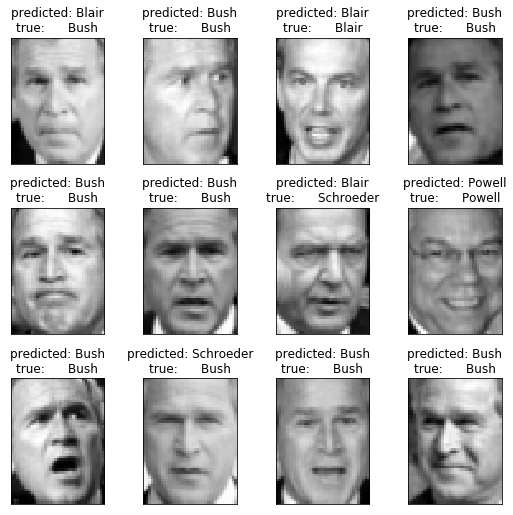

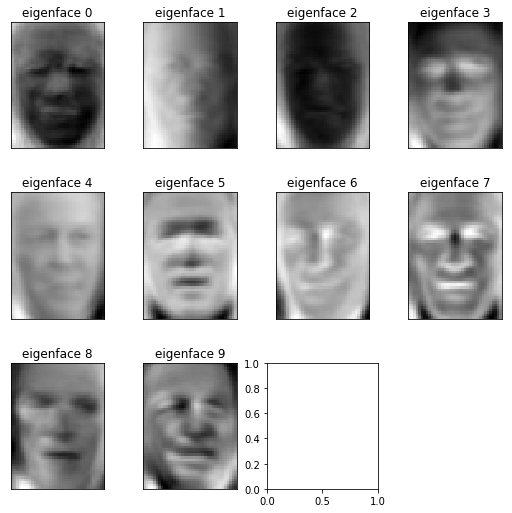

In [11]:
# %load eigenfaces.py
"""
===================================================
Faces recognition example using eigenfaces and SVMs
===================================================

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  .. _LFW: http://vis-www.cs.umass.edu/lfw/

  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html

"""



print __doc__

from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


###############################################################################
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print "Total dataset size:"
print "n_samples: %d" % n_samples
print "n_features: %d" % n_features
print "n_classes: %d" % n_classes


###############################################################################
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

def pcaTrainAndPredict(n_components):
    ###############################################################################
    # Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
    # dataset): unsupervised feature extraction / dimensionality reduction
    #n_components = 10

    print "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
    t0 = time()
    pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
    print "done in %0.3fs" % (time() - t0)

    eigenfaces = pca.components_.reshape((n_components, h, w))

    print "Projecting the input data on the eigenfaces orthonormal basis"
    t0 = time()
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    print "done in %0.3fs" % (time() - t0)


    ###############################################################################
    # Train a SVM classification model

    print "Fitting the classifier to the training set"
    t0 = time()
    param_grid = {
             'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
              }
    # for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
    clf = clf.fit(X_train_pca, y_train)
    print "done in %0.3fs" % (time() - t0)
    print "Best estimator found by grid search:"
    print clf.best_estimator_


    ###############################################################################
    # Quantitative evaluation of the model quality on the test set

    print "Predicting the people names on the testing set"
    t0 = time()
    y_pred = clf.predict(X_test_pca)
    print "done in %0.3fs" % (time() - t0)

    print classification_report(y_test, y_pred, target_names=target_names)
    print confusion_matrix(y_test, y_pred, labels=range(n_classes))
    print "variância explicada:", n_components, pca.explained_variance_ratio_[:2]

###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w);

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show();


In [ ]:
# Quanto da variância se explica na primeira componente principal? E na segunda?

pca.explained_variance_ratio_[:2]

Agora você vai experimentar usar diferentes números de componentes principais. Em um problema de classificação multiclasse como este (com mais de duas classes possíveis), a exatidão é uma métrica menos intuitiva do que no caso com duas classes. Em seu lugar, uma métrica popular é a pontuação F1.

Aprendemos sobre a pontuação F1 na lição sobre métricas de avaliação, mas mesmo se não tiver feito essa lição, tente descobrir se um bom classificador é caracterizado por uma pontuação mais alta ou baixa de F1. Você vai fazer isso variando o número de componentes principais e observando como F1 varia em resposta.

Conforme você adiciona mais componentes principais como atributos para treinar seu classificador, você espera que seu desempenho melhore ou piore?

Mude n_components para os seguintes valores: [10, 15, 25, 50, 100, 250]. Para cada número de componentes principais, observe a pontuação F1 para Ariel Sharon. Com 10 PCs, as funções de construção de gráficos no código vão quebrar, mas você deveria conseguir ver as pontuações F1. Se a pontuação F1 for maior, isso quer dizer que o desempenho do classificador melhorou ou piorou?

A redução de dimensionalidade da PCA parece estar ajudando o seu desempenho aqui? Você vê alguma evidência de sobreajuste quando usa um número muito grande de componentes principais?

In [12]:
list_n_components= [10, 15, 25, 50, 100, 250]
for n in list_n_components:
    pcaTrainAndPredict(n)
    

Extracting the top 10 eigenfaces from 966 faces
done in 0.029s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.007s
Fitting the classifier to the training set


/Users/maxfc/Anaconda/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 33.026s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.008s
                   precision    recall  f1-score   support

     Ariel Sharon       0.09      0.15      0.11        13
     Colin Powell       0.43      0.50      0.46        60
  Donald Rumsfeld       0.26      0.37      0.30        27
    George W Bush       0.69      0.59      0.64       146
Gerhard Schroeder       0.19      0.20      0.19        25
      Hugo Chavez       0.22      0.13      0.17        15
       Tony Blair       0.45      0.39      0.42        36

      avg / total       0.49      0.46      0.47       322

[[ 2  5  2  3  1  0  0]
 [ 8 30  5  8  4  1  4]
 [ 2  9 10  5  0  0  1]
 [ 8 18  9 86 12  5  8]
 [ 0  2  4  9  5  1  4]


/Users/maxfc/Anaconda/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 9.943s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.008s
                   precision    recall  f1-score   support

     Ariel Sharon       0.25      0.23      0.24        13
     Colin Powell       0.66      0.72      0.69        60
  Donald Rumsfeld       0.37      0.48      0.42        27
    George W Bush       0.75      0.74      0.74       146
Gerhard Schroeder       0.56      0.40      0.47        25
      Hugo Chavez       0.58      0.47      0.52        15
       Tony Blair       0.61      0.61      0.61        36

      avg / total       0.64      0.64      0.64       322

[[  3   3   3   4   0   0   0]
 [  5  43   3   8   0   0   1]
 [  2   3  13   9   0   0   0]
 [  2  11  15 108   5   0   

/Users/maxfc/Anaconda/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 5.430s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.009s
                   precision    recall  f1-score   support

     Ariel Sharon       0.62      0.77      0.69        13
     Colin Powell       0.73      0.85      0.78        60
  Donald Rumsfeld       0.50      0.52      0.51        27
    George W Bush       0.82      0.80      0.81       146
Gerhard Schroeder       0.62      0.60      0.61        25
      Hugo Chavez       0.82      0.60      0.69        15
       Tony Blair       0.68      0.58      0.63        36

      avg / total       0.74      0.74      0.74       322

[[ 10   2   0   1   0   0   0]
 [  2  51   2   5   0   0   0]
 [  4   2  14   6   1   0   0]
 [  0   9  10 117   4   0  

/Users/maxfc/Anaconda/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 4.848s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.017s
                   precision    recall  f1-score   support

     Ariel Sharon       0.62      0.77      0.69        13
     Colin Powell       0.80      0.88      0.84        60
  Donald Rumsfeld       0.74      0.63      0.68        27
    George W Bush       0.89      0.92      0.91       146
Gerhard Schroeder       0.79      0.76      0.78        25
      Hugo Chavez       0.91      0.67      0.77        15
       Tony Blair       0.77      0.67      0.72        36

      avg / total       0.83      0.83      0.83       322

[[ 10   1   1   1   0   0   0]
 [  1  53   0   4   1   0   1]
 [  3   2  17   5   0   0   0]
 [  0   4   4 135   0   1  

/Users/maxfc/Anaconda/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 11.071s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.033s
                   precision    recall  f1-score   support

     Ariel Sharon       0.62      0.62      0.62        13
     Colin Powell       0.82      0.92      0.87        60
  Donald Rumsfeld       0.85      0.63      0.72        27
    George W Bush       0.90      0.97      0.93       146
Gerhard Schroeder       0.91      0.80      0.85        25
      Hugo Chavez       0.91      0.67      0.77        15
       Tony Blair       0.88      0.78      0.82        36

      avg / total       0.87      0.87      0.86       322

[[  8   1   2   2   0   0   0]
 [  0  55   0   4   0   1   0]
 [  3   2  17   5   0   0   0]
 [  1   4   0 141   0   0

/Users/maxfc/Anaconda/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 30.975s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.086s
                   precision    recall  f1-score   support

     Ariel Sharon       0.56      0.69      0.62        13
     Colin Powell       0.76      0.92      0.83        60
  Donald Rumsfeld       0.86      0.67      0.75        27
    George W Bush       0.90      0.91      0.90       146
Gerhard Schroeder       0.86      0.76      0.81        25
      Hugo Chavez       0.70      0.47      0.56        15
       Tony Blair       0.85      0.78      0.81        36

      avg / total       0.84      0.84      0.83       322

[[  9   1   1   2   0   0   0]
 [  1  55   2   1   0   1   0]
 [  2   3  18   1   0   1   2]
 [  3   7   0 133   1   1

mais componentes aumenta o f1. Contudo, depois reduz. 
variância explicada permanece a mesma em todos os modelos.
semelhante a lei dos rendimentos decrescentes

quando o f1 começar a cair significa que deve-se utilizar a quantidade de componentes do experimento anterior à queda. esse é o número ideal.
